In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns

In [2]:
country_data_path = '../Data/country_data'
macro_data_path = '../Data/macro_factors'
style_data_path = '../Data/style_factors'
cluster_path = '../Outputs/country_clusters'

## Load Data

### Read country sovereign bond index data

In [160]:
ticker_all = pd.read_csv(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_summary.csv'), skipinitialspace=True)

In [161]:
ticker = ticker_all.loc[(ticker_all['Number of Issues'] > 1) & (ticker_all['Sum of Market Value (mm, USD)'] > 1000), :].copy()

In [162]:
ticker['Country'] = ticker['Full Index Name'].apply(lambda x:' '.join(x.split()[4:-2]))

In [165]:
ticker['Index Full Name'] = ticker['Index BBG Ticker'] + ' Index'

In [166]:
ticker[['Index Full Name', 'Country']].head()

,Index Full Name,Country
0,GDID Index,Indonesia
1,GDTR Index,Turkey
2,GDMX Index,Mexico
3,GDEG Index,Egypt
4,GDPH Index,Philippines


In [167]:
ticker['Country'].unique()

array(['Indonesia', 'Turkey', 'Mexico', 'Egypt', 'Philippines', 'Bahrain',
       'Brazil', 'Colombia', 'Dominican Republic', 'Panama', 'Qatar',
       'South Africa', 'China', 'Israel', 'Ghana', 'Peru', 'Russia',
       'Sri Lanka', 'Chile', 'El Salvador', 'Ukraine', 'Nigeria',
       'Paraguay', 'South Korea', 'Uruguay', 'Guatemala', 'Romania',
       'Argentina', 'Costa Rica', 'Angola', 'Belarus', 'Jamaica',
       'Jordan', 'Kenya', 'Morocco', 'Pakistan', 'Bahamas', 'Hungary',
       'Kazakhstan', 'Malaysia', 'Mongolia', 'Poland', 'Azerbaijan',
       'Ecuador', 'Gabon', 'Honduras', 'Ivory Coast', 'Senegal',
       'Trinidad & Tobago', 'Zambia', 'Armenia', 'Croatia', 'Iraq',
       'Slovenia'], dtype=object)

In [168]:
ticker_dict = pd.Series(data=ticker['Country'].values, index=ticker['Index Full Name']).to_dict()

In [169]:
bnd_idx_price = pd.read_excel(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_data.xlsx'), 
                            sheet_name='px_last data',
                            skiprows=3,
                            header=0)

In [172]:
bnd_idx_price.drop(index=[0, 1], inplace=True)

In [173]:
bnd_idx_price.rename(columns={"Unnamed: 0":"Date"}, inplace=True)

In [174]:
bnd_idx_price.set_index('Date', inplace=True)

In [175]:
bnd_idx_price = bnd_idx_price.astype('float')

In [176]:
bnd_idx_price_monthly = bnd_idx_price.resample('M').last()

In [177]:
bnd_idx_price_monthly.replace(0, np.nan, inplace=True)

### Read Macro Factors Data

In [181]:
credit = pd.read_csv(os.path.join(macro_data_path, 'LF98TRUU_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['credit'])
currency = pd.read_csv(os.path.join(macro_data_path, 'MXEF0CX0_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['currency'])
equity = pd.read_csv(os.path.join(macro_data_path, 'WHANWIHD_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['equity'])

In [182]:
rates = pd.read_csv(os.path.join(macro_data_path, 'JPM_GBIEM.csv'), skiprows=7, header=None, index_col=0, names=['rates_last', 'rates_mid'])
rates.index = pd.to_datetime(rates.index)
rates = rates.sort_index()
rates = rates[['rates_last']]
rates.columns = ['rates']

In [183]:
macro_factors = credit.join(currency, how='inner').join(equity, how='inner').join(rates, how='inner')

In [184]:
macro_factors_monthly = macro_factors.resample('M').last()

In [185]:
macro_factors_monthly = macro_factors_monthly.astype('float')

### Read 3-Months LIBOR data

In [186]:
libor = pd.read_csv('../Data/others/USD3MTD156N.csv', index_col=0)
libor.columns = ['3M_libor']
libor['3M_libor'] = libor['3M_libor'].replace(['.'], np.nan)
libor.fillna(method='ffill')
libor = libor.apply(pd.to_numeric)
libor.index = pd.to_datetime(libor.index)

libor_monthly = libor.resample('M').first() / 1200 # convert annual data in % to a monthly return
libor_monthly = libor_monthly.shift(1).dropna() # using first data of the month and shift by a period, to match bond index return's date convention - end of month date represents return earned over that month

## Regression

In [187]:
bnd_index_ret = np.log(bnd_idx_price_monthly).diff()

In [188]:
bnd_index_ret.describe()

,GDAM Index,GDAO Index,GDAR Index,GDAW Index,GDAZ Index,GDBB Index,GDBG Index,GDBH Index,GDBO Index,GDBR Index,...,GDTH Index,GDTN Index,GDTR Index,GDTT Index,GDUA Index,GDUY Index,GDVE Index,GDVN Index,GDZA Index,GDZM Index
count,81.000000,101.000000,29.000000,99.000000,82.000000,168.000000,252.000000,211.000000,247.000000,252.000000,...,252.000000,225.000000,252.000000,193.000000,250.000000,252.000000,252.000000,193.000000,252.000000,99.000000
mean,0.006047,0.006631,-0.030350,0.004066,0.005400,0.003300,0.004364,0.000498,-0.028352,0.008063,...,0.002174,0.002953,0.007207,0.005278,0.009189,0.007198,0.005348,0.005765,0.006130,-0.000636
std,0.025372,0.105290,0.099993,0.015719,0.026430,0.034696,0.019377,0.004146,0.375968,0.042023,...,0.006958,0.012721,0.036664,0.022922,0.063254,0.057038,0.068971,0.030727,0.026784,0.080635
min,-0.135726,-0.893634,-0.338934,-0.069766,-0.132276,-0.165833,-0.147381,-0.028790,-1.386294,-0.210894,...,-0.026065,-0.072523,-0.180034,-0.184918,-0.479180,-0.381083,-0.552361,-0.281614,-0.191556,-0.457734
25%,-0.000509,-0.009947,-0.046797,0.000253,-0.006614,-0.004802,0.000000,0.000000,-0.223144,-0.008954,...,0.000000,0.000000,-0.009614,-0.000784,-0.008629,-0.008027,-0.013282,-0.001286,-0.006053,-0.031190
50%,0.007061,0.007067,-0.004017,0.004497,0.006777,0.000000,0.000000,0.000000,0.000000,0.011402,...,0.000000,0.000000,0.009581,0.006011,0.009573,0.008662,0.005048,0.007093,0.007877,-0.000797
75%,0.014938,0.024001,0.026629,0.007867,0.020004,0.012359,0.010756,0.000000,0.108293,0.025192,...,0.000511,0.006020,0.025770,0.014888,0.030000,0.031095,0.035912,0.017246,0.019398,0.028655
max,0.076157,0.337432,0.129239,0.071567,0.055869,0.170942,0.068749,0.022393,1.860752,0.233548,...,0.035111,0.062714,0.132061,0.084104,0.326299,0.297292,0.223687,0.099489,0.100748,0.327798


In [189]:
bnd_index_ret.replace(0, np.nan, inplace=True)

In [190]:
bnd_index_excess_ret = bnd_index_ret.subtract(libor_monthly['3M_libor'], axis=0).dropna(axis=0, how='all')

In [191]:
macro_factors_ret = np.log(macro_factors_monthly).diff().dropna()

In [192]:
macro_factors_ret.describe()

,credit,currency,equity,rates
count,191.000000,191.000000,191.000000,191.000000
mean,0.005827,0.002256,0.006560,0.003693
std,0.027960,0.019484,0.040996,0.012621
min,-0.173244,-0.078636,-0.171625,-0.039949
25%,-0.003483,-0.006882,-0.012876,-0.003229
50%,0.007352,0.003989,0.013603,0.005135
75%,0.016999,0.013584,0.030295,0.010941
max,0.114263,0.050544,0.114004,0.066541


In [193]:
results_df = pd.DataFrame()
results_dict = {} 

cols = ['const'] + macro_factors_ret.columns.tolist()
beta_cols = [x + '_beta' for x in cols]
tval_cols = [x + '_tval' for x in cols]

for bnd_index in ticker_dict:
    
    country = ticker_dict[bnd_index]
    temp = bnd_index_excess_ret[bnd_index].dropna().to_frame().join(macro_factors_ret, how='inner')
    
    if temp.shape[0] > 30:

        y = temp.iloc[:, 0]
        X = temp.iloc[:, 1:]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()

        betas = results.params
        tvalues = results.tvalues
        rsq_adj = results.rsquared_adj
        f_pvalue = results.f_pvalue
        start_date = y.index.min().strftime('%Y%m')
        temp_results_df = pd.DataFrame(data=np.r_[betas, tvalues, rsq_adj, f_pvalue], 
                                       index=beta_cols + tval_cols + ['rsq_adj', 'f_pvalue']).T
        temp_results_df['country'] = country
        temp_results_df['start_date'] = start_date
        results_df = results_df.append(temp_results_df)
    
        results_dict[country] = results


In [194]:
results_df

,const_beta,credit_beta,currency_beta,equity_beta,rates_beta,const_tval,credit_tval,currency_tval,equity_tval,rates_tval,rsq_adj,f_pvalue,country,start_date
0,-0.004352,0.652970,0.033462,-0.034148,1.504776,-2.738879,7.333018,0.294827,-0.573248,10.144283,0.693218,1.721245e-47,Indonesia,200502
0,-0.003559,0.197976,0.023381,0.075436,1.668020,-2.348766,2.331310,0.216011,1.327876,11.790931,0.631059,4.453373e-40,Turkey,200502
0,-0.001289,0.318027,-0.007878,-0.078209,1.116598,-0.962752,4.237478,-0.082352,-1.557732,8.931000,0.507166,1.791194e-28,Mexico,200502
0,-0.000666,0.213845,-0.022028,0.038904,0.865868,-0.297798,1.706530,-0.137916,0.464094,4.147885,0.203410,1.938288e-09,Egypt,200502
0,-0.000003,0.373244,-0.099323,-0.058759,1.043488,-0.003115,6.292893,-1.313806,-1.480906,10.561005,0.613833,3.022625e-38,Philippines,200502
0,-0.000819,0.275178,0.248353,-0.108467,1.187598,-0.637565,3.820808,2.705430,-2.251306,9.898544,0.600436,7.059733e-37,Brazil,200502
0,-0.001587,0.438241,-0.018990,-0.041249,1.137120,-1.278108,6.297013,-0.214079,-0.885998,9.808160,0.633076,2.683372e-40,Colombia,200502
0,-0.002551,1.388732,-0.244148,-0.232054,0.927339,-1.000472,9.716472,-1.340196,-2.427017,3.894828,0.532776,1.312029e-30,Dominican Republic,200502
0,-0.001504,0.578964,-0.114146,-0.101863,1.139992,-1.180143,8.105372,-1.253733,-2.131713,9.580380,0.634996,1.651886e-40,Panama,200502
0,-0.000756,0.508978,-0.129209,-0.114119,0.620711,-0.715583,8.592736,-1.711400,-2.879948,6.290449,0.523604,7.870681e-30,Qatar,200502


In [195]:
results_df.describe()

,const_beta,credit_beta,currency_beta,equity_beta,rates_beta,const_tval,credit_tval,currency_tval,equity_tval,rates_tval,rsq_adj,f_pvalue
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,4.600000e+01
mean,-0.002051,0.803840,0.010221,-0.048138,0.703414,-0.588758,5.259748,-0.168699,-0.842491,4.805043,0.476851,1.164141e-04
std,0.004059,0.827438,0.271613,0.095099,0.472486,1.093747,2.551725,1.464597,1.241704,3.526131,0.147243,7.868348e-04
min,-0.016079,0.042397,-0.418816,-0.278871,-0.348045,-2.738879,0.581424,-3.662358,-3.699185,-0.839482,0.088491,1.721245e-47
25%,-0.003205,0.313794,-0.162113,-0.090323,0.399720,-1.177751,3.217715,-1.256990,-1.822367,1.330967,0.375153,1.844184e-30
50%,-0.000790,0.565533,-0.038420,-0.059434,0.746665,-0.461136,5.617113,-0.291194,-0.755659,4.325311,0.508083,1.744646e-21
75%,0.000221,0.973029,0.043321,-0.006648,1.040915,0.158309,7.255404,0.549808,-0.078083,7.928804,0.596452,1.057839e-15
max,0.002459,4.676858,0.802928,0.184428,1.800138,1.802004,10.186300,3.753299,1.903005,11.790931,0.693218,5.336951e-03


## Regression Results by Cluster

In [196]:
bond_idx_clusters = pd.read_pickle(os.path.join(cluster_path, 'clusters_bond_idx_ret_full.pkl'))
bond_idx_clusters.head()

,Countries,cluster_label
0,Bulgaria,0
1,Bolivia,0
2,Ukraine,0
3,Venezuela,0
4,El Salvador,1


In [197]:
set(bond_idx_clusters['Countries']) - set(results_df['country'])

{'Bolivia', 'Bulgaria', 'Lebanon', 'Venezuela'}

In [198]:
set(results_df['country']) - set(bond_idx_clusters['Countries'])

{'Angola',
 'Armenia',
 'Azerbaijan',
 'Bahamas',
 'Belarus',
 'Ecuador',
 'Gabon',
 'Ghana',
 'Honduras',
 'Iraq',
 'Kenya',
 'Mongolia',
 'Pakistan',
 'Paraguay',
 'Romania',
 'Senegal',
 'Slovenia',
 'Sri Lanka',
 'Trinidad & Tobago',
 'Zambia'}

In [199]:
results_with_cluster = results_df.merge(bond_idx_clusters, left_on='country', right_on='Countries')

In [200]:
beta_reformatted = results_with_cluster.set_index('cluster_label')[beta_cols].stack().to_frame().reset_index()
beta_reformatted.columns = ['cluster', 'beta', 'value']

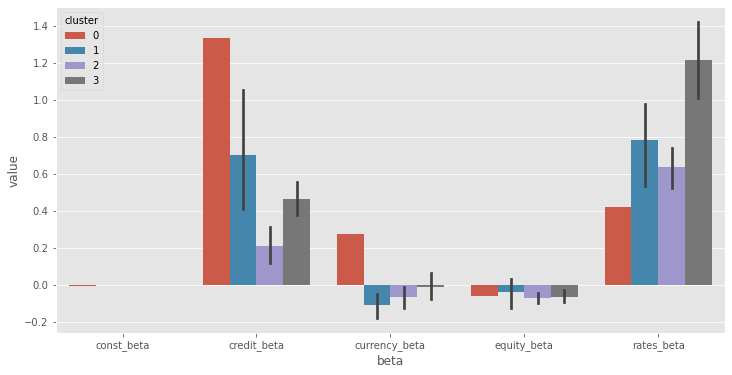

In [201]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='beta', y='value', data=beta_reformatted, hue='cluster')

In [202]:
tval_reformatted = results_with_cluster.set_index('cluster_label')[tval_cols].stack().to_frame().reset_index()
tval_reformatted.columns = ['cluster', 'tval', 'value']

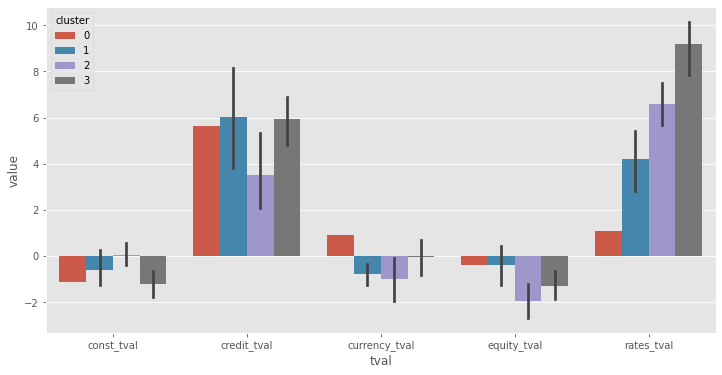

In [203]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='tval', y='value', data=tval_reformatted, hue='cluster')

In [204]:
beta_df = results_with_cluster.set_index('country')[beta_cols].T

In [205]:
tval_df = results_with_cluster.set_index('country')[tval_cols].T

In [206]:
def plot_cluster_betas(clusters_df, betas_df, cluster_n, ylim, ytitle):
    # Plot betas for each cluster
    cluster_list = list(clusters_df[clusters_df['cluster_label']==cluster_n]['Countries'])
    betas_df_tmp = betas_df[cluster_list]
    
    #no_const = betas_df_tmp.T[betas_df_tmp.T.columns[~betas_df_tmp.T.columns.isin(['const'])]]
    betas_df_tmp.T.plot(kind='bar', rot=0, figsize=(16,3))
    plt.legend(loc='upper left')
    plt.ylabel(ytitle)
    plt.ylim(-ylim,ylim)

def plot_multiple_clusters(clusters_df, betas_df, ylim, ytitle):
    all_cluster_labels = list(clusters_df['cluster_label'].unique())
    #fig, ax = plt.subplots(nrows=len(all_cluster_labels), constrained_layout=True, figsize=(12,8))
    for label_ in all_cluster_labels:
        plot_cluster_betas(clusters_df, betas_df, label_, ylim, ytitle)

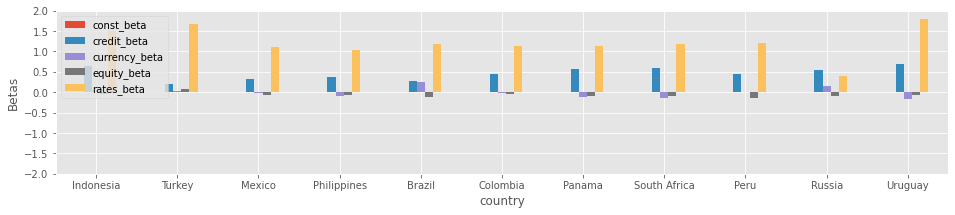

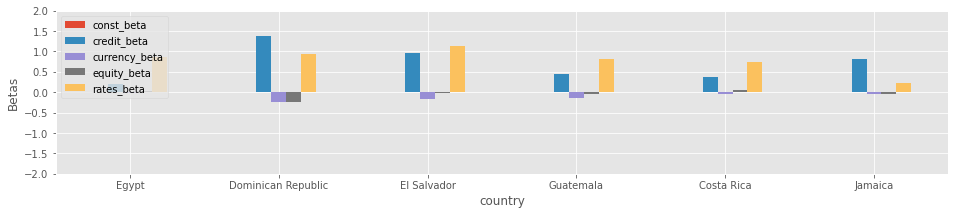

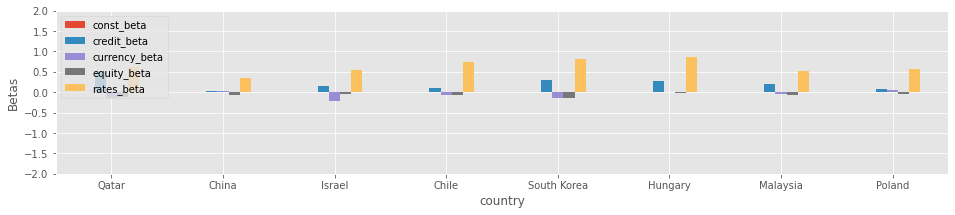

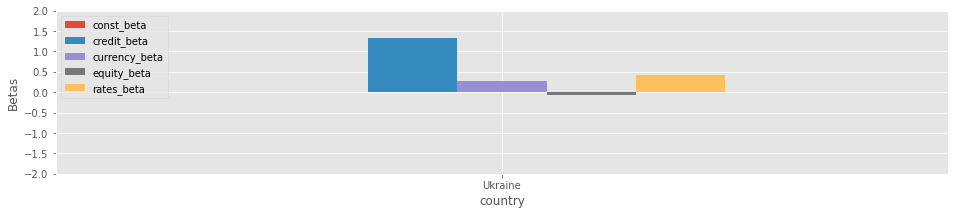

In [207]:
plot_multiple_clusters(results_with_cluster, beta_df, 2, 'Betas')

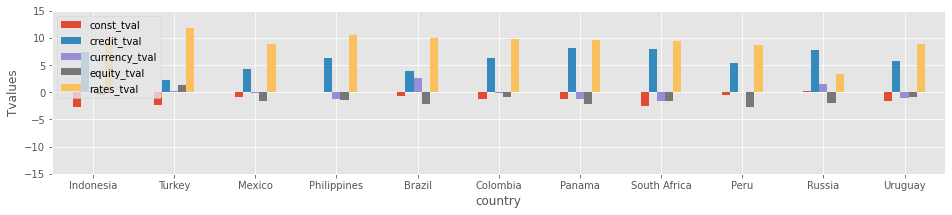

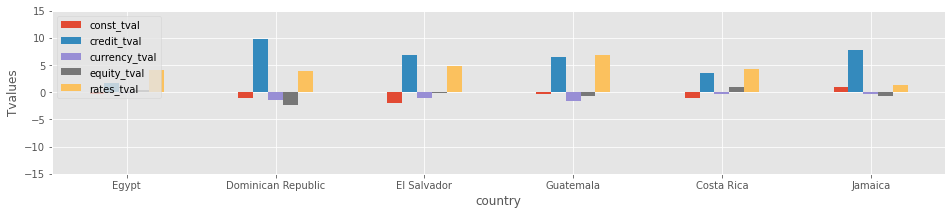

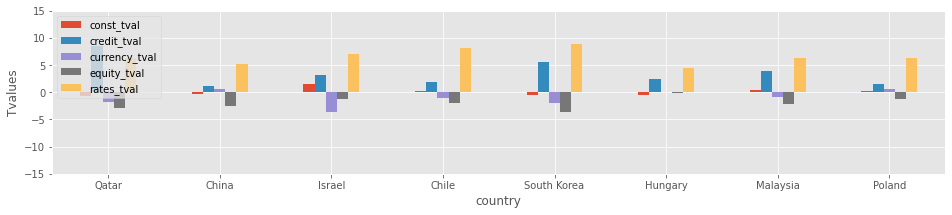

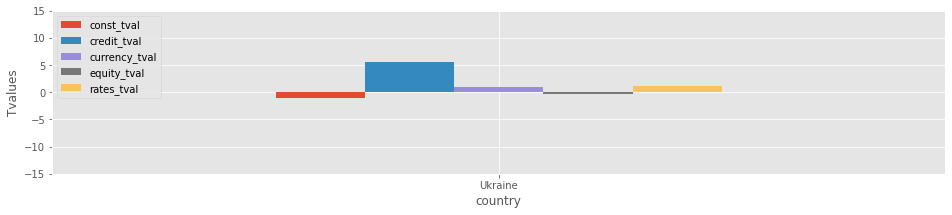

In [208]:
plot_multiple_clusters(results_with_cluster, tval_df, 15, 'Tvalues')

In [98]:
# read gov oas data for all sov bond indices
oas1 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats1.csv'), header=1, parse_dates=[0], nrows=7574, skipinitialspace=True)
oas1.dropna(axis=1, how="all", inplace=True) # delete empty column

oas2 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats2.csv'), header=1, parse_dates=[0], nrows=7552, skipinitialspace=True)
oas2.dropna(axis=1, how="all", inplace=True)

oas3 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats3.csv'), header=1, parse_dates=[0], nrows=6764, skipinitialspace=True)
oas3.dropna(axis=1, how="all", inplace=True)

oas4 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats4.csv'), header=1, parse_dates=[0], nrows=6912, skipinitialspace=True)
oas4.dropna(axis=1, how="all", inplace=True)

In [113]:
oas = oas1[oas1['Date'] > "20050101"].merge(oas2, on='Date').merge(oas3, on='Date').merge(oas4, on='Date')

In [119]:
oas_monthly = oas.set_index('Date').resample('M').last()

In [121]:
oas_monthly

,GDID,GDTR,GDMX,GDEG,GDPH,GDBH,GDBR,GDCO,GDDO,GDPA,...,GDBO,GDBG,GDFJ,GDGE,GDIS,GDLV,GDLB,GDMZ,GDES,GDVE
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,201.0,260.0,133.0,108.0,417.0,57.0,338.0,317.0,736.0,270.0,...,NaN,82.0,NaN,NaN,NaN,NaN,346.0,NaN,NaN,372.0
2005-02-28,174.0,212.0,129.0,94.0,386.0,59.0,313.0,286.0,786.0,240.0,...,NaN,68.0,NaN,NaN,NaN,NaN,364.0,NaN,NaN,351.0
2005-03-31,213.0,280.0,154.0,100.0,405.0,72.0,388.0,348.0,876.0,293.0,...,NaN,100.0,NaN,NaN,NaN,NaN,397.0,NaN,NaN,379.0
2005-04-30,304.0,323.0,163.0,103.0,431.0,71.0,387.0,345.0,688.0,265.0,...,NaN,102.0,NaN,NaN,NaN,NaN,446.0,NaN,NaN,404.0
2005-05-31,287.0,282.0,137.0,92.0,414.0,64.0,343.0,287.0,458.0,247.0,...,NaN,102.0,NaN,NaN,NaN,NaN,438.0,NaN,NaN,409.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30,177.0,631.0,248.0,637.0,134.0,458.0,302.0,248.0,451.0,174.0,...,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-31,163.0,644.0,224.0,597.0,120.0,424.0,279.0,231.0,418.0,158.0,...,629.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-30,141.0,499.0,198.0,515.0,111.0,371.0,240.0,212.0,363.0,151.0,...,532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
oas_monthly.isna().sum().sort_values(ascending=False).head(60)

GDDZ    172
GDMZ    164
GDTH    164
GDFJ    144
GDES    143
GDGR    129
GDIS    123
GDKE    113
GDAM    111
GDAZ    110
GDKZ    100
GDRW    100
GDHN    100
GDSI     97
GDPY     96
GDBZ     95
GDMN     95
GDBO     93
GDAW     92
GDZM     92
GDAO     91
GDSK     88
GDRO     85
GDLV     84
GDBG     84
GDJO     82
GDNA     82
GDCI     80
GDSN     76
GDBY     71
GDMA     64
GDCN     61
GDBS     59
GDLT     57
GDBB     52
GDGE     48
GDTN     45
GDNG     45
GDGA     35
GDLK     33
GDGH     33
GDVE     32
GDBH     29
GDHR     27
GDAR     19
GDIQ     12
GDLB      9
GDEC      6
GDCS      5
GDDO      0
GDZA      0
GDQA      0
GDVN      0
GDPA      0
GDPL      0
GDCO      0
GDBR      0
GDPH      0
GDEG      0
GDMX      0
dtype: int64